In [542]:
## imports and global variables
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

CHARACTERISTICS_FILENAME = "Public_School_Characteristics_-_Current.csv"
LOCATION_FILENAME = "Public_School_Locations_-_Current.csv"
POVERTY_FILENAME = "School_Neighborhood_Poverty_Estimates_Current_-8025457622334316475.csv"
SCORES_FILENAME = "seda_school_pool_cs_5.0.csv"
EXTRA_FILENAME = "seda_cov_school_pool_5.0.csv"

## citations
# https://data-nces.opendata.arcgis.com
# https://edopportunity.org/get-the-data/seda-archive-downloads/#testscore-2023

In [544]:
## datasets import into dataframes
char_df = pd.read_csv(CHARACTERISTICS_FILENAME)
loc_df = pd.read_csv(LOCATION_FILENAME)
pov_df = pd.read_csv(POVERTY_FILENAME)
scores_df = pd.read_csv(SCORES_FILENAME)
extra_df = pd.read_csv(EXTRA_FILENAME)

C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\2718402799.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  char_df = pd.read_csv(CHARACTERISTICS_FILENAME)
C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\2718402799.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  loc_df = pd.read_csv(LOCATION_FILENAME)


In [546]:
## merging dataframes
pov_df = pov_df.rename(columns={"School ID": "NCESSCH"})
scores_df = scores_df.rename(columns={"sedasch": "NCESSCH"})
extra_df = extra_df.rename(columns={"sedasch": "NCESSCH"})

c_l_df = pd.merge(char_df, loc_df, on="NCESSCH")
c_l_p_df = pd.merge(c_l_df, pov_df, on="NCESSCH")
c_l_p_s_df = pd.merge(c_l_p_df, scores_df, on="NCESSCH")
df = pd.merge(c_l_p_s_df, extra_df, on="NCESSCH")

In [548]:
## feature selection and renaming
features = ["charter",
           "urbanicity",
           "totenrl",
           "perfrl",
           "perecd",
           "lep",
           "gifted_tot",
           "STUTERATIO",
           "cs_mn_avg_ol",
           "LSTATE"]


merged_df = df[features]

new_feature_names = ["charter", 
                     "urbanicity",
                     "total_enrollment",
                     "per_reduced_or_free",
                     "per_econ_disadvantaged",
                     "not_english_prof",
                     "total_gifted",
                     "student_to_teacher_ratio",
                     "average_test_scores",
                     "STUSPS"]

merged_df.columns = new_feature_names

In [550]:
## quantify and drop NaN values
locale_mapping = {"Rural": 1,
                  "Town": 2,
                  "City": 3}

merged_df["urbanicity"] = merged_df["urbanicity"].map(locale_mapping)
merged_df.dropna(inplace=True)

C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\1912219577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["urbanicity"] = merged_df["urbanicity"].map(locale_mapping)
C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\1912219577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.dropna(inplace=True)


In [552]:
## normalize
columns_to_normalize = ["charter", 
                     "urbanicity",
                     "total_enrollment",
                     "per_reduced_or_free",
                     "per_econ_disadvantaged",
                     "not_english_prof",
                     "total_gifted",
                     "student_to_teacher_ratio",
                     "average_test_scores"]

scaler = MinMaxScaler()
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\4234169647.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])


In [554]:
## create target and features for train test split
lin_reg_features = merged_df.drop(["average_test_scores", "STUSPS"], axis=1)
lin_reg_target = merged_df["average_test_scores"]

In [556]:
## train test split
lin_reg_X_train, lin_reg_X_test, lin_reg_y_train, lin_reg_y_test = train_test_split(lin_reg_features,
                                                    lin_reg_target, 
                                                    test_size=0.01, 
                                                    random_state=0)

In [558]:
## modelling, fitting, predictions
lin_reg_model = LinearRegression()
lin_reg_model.fit(lin_reg_X_train, lin_reg_y_train)
lin_reg_predictions = lin_reg_model.predict(lin_reg_X_test)

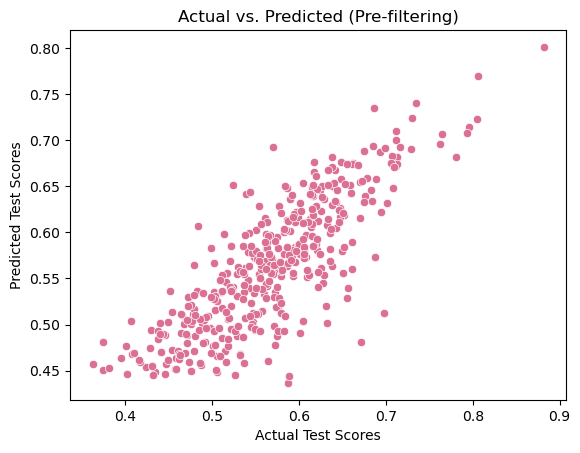

In [560]:
## plotting actual vs. predicted
sns.scatterplot(x=lin_reg_y_test, y=lin_reg_predictions, color="palevioletred")
plt.title("Actual vs. Predicted (Pre-filtering)")
plt.ylabel("Predicted Test Scores")
plt.xlabel("Actual Test Scores")
plt.show()

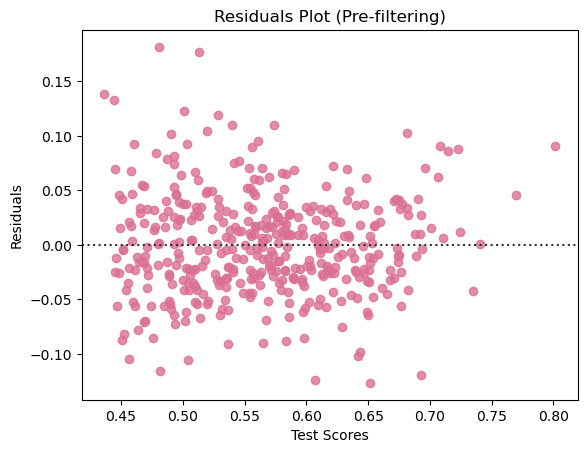

In [562]:
## residuals and plotting
lin_reg_residuals = lin_reg_y_test - lin_reg_predictions

sns.residplot(x=lin_reg_predictions, y=lin_reg_residuals, color="palevioletred")
plt.title("Residuals Plot (Pre-filtering)")
plt.ylabel("Residuals")
plt.xlabel("Test Scores")
plt.show()

In [564]:
## k-fold cross validate
lin_reg_scores = cross_validate(lin_reg_model, lin_reg_features, lin_reg_target, scoring=("r2", "neg_mean_squared_error"), return_train_score=True)

print("R2 =", lin_reg_scores["train_r2"].mean())
print("MSE =", -scores["test_neg_mean_squared_error"].mean())

R2 = 0.6557338170004426
MSE = 0.0022235198799020837


In [566]:
## discover which features are most correlated
coefficients = lin_reg_model.coef_

features_and_co = pd.DataFrame({"feature": lin_reg_features.columns, "coefficient": coefficients})
features_and_co["coefficient"] = features_and_co["coefficient"].abs()
features_and_co = features_and_co.sort_values(by="coefficient", ascending=False)

features_and_co

,feature,coefficient
4,per_econ_disadvantaged,0.197553
7,student_to_teacher_ratio,0.159596
6,total_gifted,0.145481
3,per_reduced_or_free,0.075457
2,total_enrollment,0.018533
5,not_english_prof,0.007791
0,charter,0.002983
1,urbanicity,0.000079


C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\1291936770.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  features_barplot = sns.barplot(features_and_co, x="feature", y="coefficient", palette="magma")
C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\1291936770.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  features_barplot.set_xticklabels(labels=(features_and_co["feature"]), rotation=90)


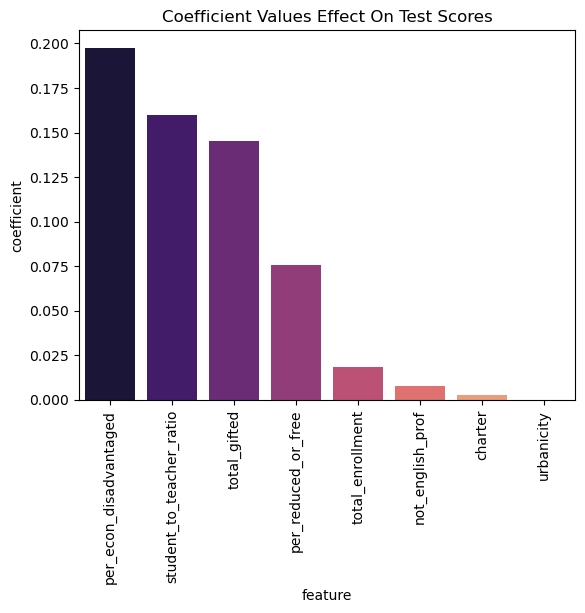

In [568]:
## plotting
features_barplot = sns.barplot(features_and_co, x="feature", y="coefficient", palette="magma")
features_barplot.set_xticklabels(labels=(features_and_co["feature"]), rotation=90) 
plt.title("Coefficient Values Effect On Test Scores")
plt.show()

In [570]:
def outlier_filtering(df, numeric_columns):
    filtered_df = df.copy()

    for i in numeric_columns:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        filtered_df = filtered_df[(filtered_df[i] >= lower) & (filtered_df[i] <= upper)]

    return filtered_df

filtered_df = outlier_filtering(merged_df, [("total_gifted"),
                                                     ("total_enrollment"),
                                                     ("not_english_prof"), 
                                                     ("urbanicity"), 
                                                     ("per_reduced_or_free"), 
                                                     ("student_to_teacher_ratio"), 
                                                     ("per_econ_disadvantaged")])

In [572]:
## is the linear regression improved?
filtered_lin_reg_features = filtered_df.drop(["average_test_scores", "STUSPS"], axis=1)
filtered_lin_reg_target = filtered_df["average_test_scores"]

filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test = train_test_split(filtered_lin_reg_features,
                                                    filtered_lin_reg_target, 
                                                    test_size=0.02, ## made bigger because this is a smaller sample after removing outliers
                                                    random_state=0)

In [574]:
## modelling, fitting, predictions
filtered_lin_reg_model = LinearRegression()
filtered_lin_reg_model.fit(filtered_X_train, filtered_y_train)
filtered_lin_reg_predictions = filtered_lin_reg_model.predict(filtered_X_test)

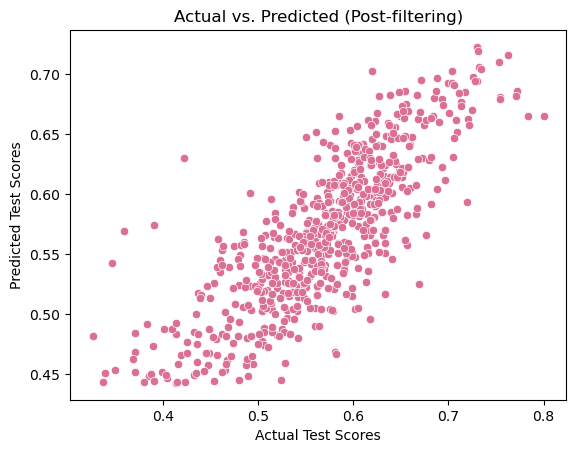

In [576]:
## actual vs predicted plotting
sns.scatterplot(x=filtered_y_test, y=filtered_lin_reg_predictions, color="palevioletred")
plt.title("Actual vs. Predicted (Post-filtering)")
plt.ylabel("Predicted Test Scores")
plt.xlabel("Actual Test Scores")
plt.show()

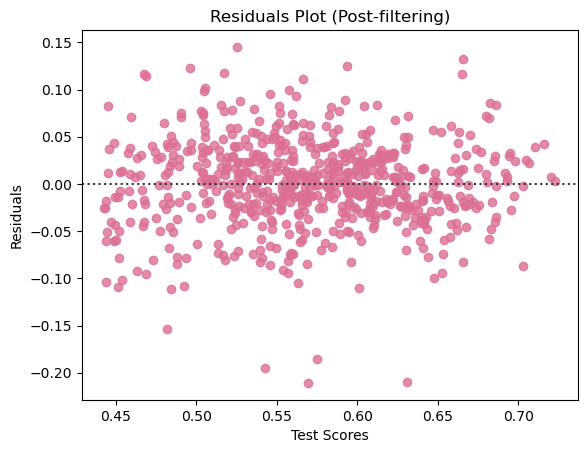

In [578]:
filtered_residuals = filtered_y_test - filtered_lin_reg_predictions

sns.residplot(x=filtered_lin_reg_predictions, y=filtered_residuals, color="palevioletred")
plt.title("Residuals Plot (Post-filtering)")
plt.ylabel("Residuals")
plt.xlabel("Test Scores")
plt.show()

In [580]:
## k-fold cross validate
filtered_lin_reg_scores = cross_validate(filtered_lin_reg_model, filtered_lin_reg_features, filtered_lin_reg_target, cv=5, scoring=("r2", "neg_mean_squared_error"), return_train_score=True)

print("R2 =", filtered_lin_reg_scores["train_r2"].mean())
print("MSE =", -filtered_lin_reg_scores["test_neg_mean_squared_error"].mean())

R2 = 0.6462363336014635
MSE = 0.002198917039712467


In [582]:
## geopandas (continental)
gdf = gpd.read_file("geodata/tl_2024_us_state.shp")

merged_gdf = gdf.merge(merged_df.sample(1000), on="STUSPS")

## removing alaska and hawaii for visualization
merged_gdf = merged_gdf[~merged_gdf["STUSPS"].isin (["HI"])]
merged_gdf = merged_gdf[~merged_gdf["STUSPS"].isin (["AK"])]

In [583]:
## sort into state-by-state data
def state_by_state(df, to_average):
    state_avg_df = df.groupby('STUSPS')[to_average].mean().reset_index()
    state_avg_df = gdf.merge(state_avg_df, on="STUSPS")
    
    return state_avg_df

state_gdf = state_by_state(merged_gdf, [("average_test_scores"), ("per_econ_disadvantaged")])

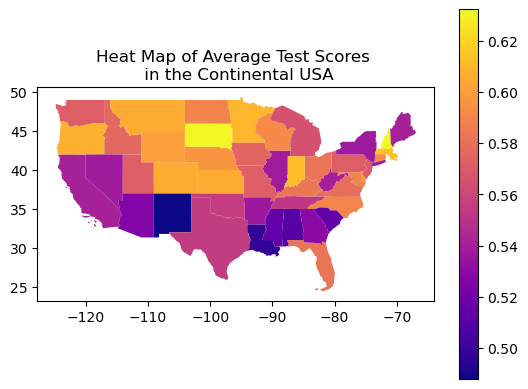

In [586]:
## average test scores heat map
state_gdf.plot(column="average_test_scores", legend="True", cmap="plasma")
plt.title("Heat Map of Average Test Scores \n in the Continental USA")
plt.show()

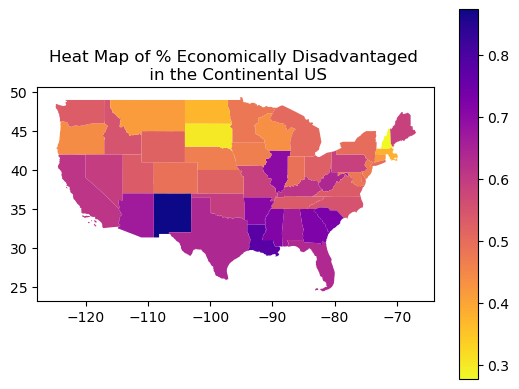

In [588]:
## percent economically disadvantaged
state_gdf.plot(column="per_econ_disadvantaged", legend="True", cmap="plasma_r")
plt.title("Heat Map of % Economically Disadvantaged \n in the Continental US")
plt.show()

In [590]:
## random forest feature selection using linear reg. features
rand_forest_features = filtered_lin_reg_features
rand_forest_target = filtered_lin_reg_target

In [592]:
## random forest train test split
rand_forest_X_train, rand_forest_X_test, rand_forest_y_train, rand_forest_y_test = train_test_split(rand_forest_features,
                                                    rand_forest_target, 
                                                    test_size=0.02, 
                                                    random_state=0)

In [594]:
## create, fit model, predictions
rand_forest_model = RandomForestRegressor(n_estimators=50, random_state=0)
rand_forest_model.fit(rand_forest_X_train, rand_forest_y_train)
predictions = rand_forest_model.predict(rand_forest_X_test)

In [596]:
## cross validate
rand_forest_scores = cross_validate(rand_forest_model, rand_forest_features, rand_forest_target, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

print("R2 =", rand_forest_scores["train_r2"].mean())
print("MSE =", -rand_forest_scores["test_neg_mean_squared_error"].mean())

R2 = 0.9531231834630839
MSE = 0.0022235198799020837


In [597]:
## find most important features
importances = rand_forest_model.feature_importances_
feature_importance_df = pd.DataFrame({"feature": rand_forest_X_train.columns, "importance": importances})
print(feature_importance_df.sort_values(by="importance", ascending=False))

                    feature  importance
4    per_econ_disadvantaged    0.654299
3       per_reduced_or_free    0.112031
2          total_enrollment    0.059168
7  student_to_teacher_ratio    0.058815
5          not_english_prof    0.048835
6              total_gifted    0.048547
1                urbanicity    0.014684
0                   charter    0.003622


C:\Users\aryan\AppData\Local\Temp\ipykernel_31260\2165260391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x="importance", y="feature", order=feature_importance_df.sort_values("importance").feature, palette="magma")


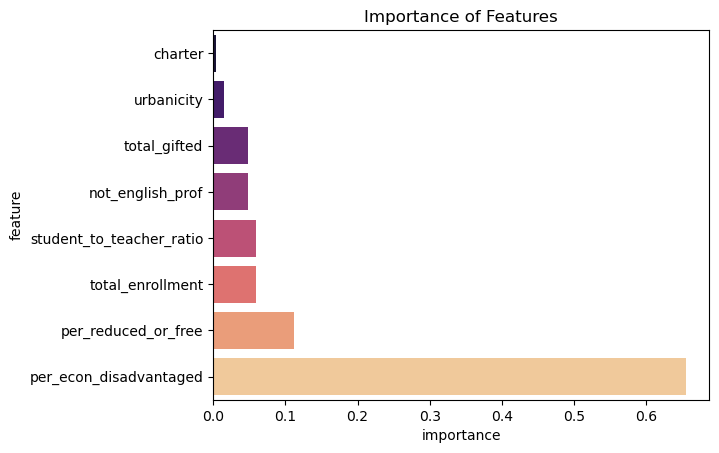

In [600]:
## bar plotting feature importance
sns.barplot(data=feature_importance_df, x="importance", y="feature", order=feature_importance_df.sort_values("importance").feature, palette="magma")
plt.title("Importance of Features")
plt.show()